In [1]:
# imports
import tensorflow as tf
import numpy as np

import datasets
from datasets import load_dataset
from tqdm import tqdm
from transformers import AutoTokenizer
from einops import rearrange, repeat
import tensorflow_text as tft

#from google.colab import files
import json

import matplotlib.pyplot as plt
import sentencepiece as sp
import re
import keras 

2024-04-09 21:01:40.132251: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 21:01:40.227666: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 21:01:40.600035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 21:01:41.520433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#bible = files.upload()

Saving bible.txt to bible.txt


In [4]:
def data_cleaning():
    """
    clean the bible data file by removing special characters and converting all letters to lower case.
    cleaned file is saved in the same directory.
    """
    # read the text file
    bible_file = open("bible.txt")
    bible_str = bible_file.read()
    # preprocessing
    # convert to lowercase
    bible_str = bible_str.lower()
    # remove all special characters and numbers except \n
    bible_str = re.sub(r'[^A-Za-z\n]+', ' ', bible_str)
    # write the preprocessed text into the file
    bible_file = open("bible.txt", "w")
    bible_file.write(bible_str)
    # close the file
    bible_file.close()

def train_tokenizer():
    """
    Sentencepiece tokenizer is trained on the bible dataset with vocabulary size of 2000.
    returns:
        trained tokenizer
    """
    vocab_size=2000
    # Train the SentencePiece tokenizer on our text file
    sp.SentencePieceTrainer.train(input="bible.txt", model_prefix='tokenizer_model', model_type="unigram", vocab_size=vocab_size)

    # load the trained model file in the correct format
    trained_tokenizer_model = tf.io.gfile.GFile('tokenizer_model.model', "rb").read()

    # load the model as a tokenizer that we can use for our models
    tokenizer = tft.SentencepieceTokenizer(
        model=trained_tokenizer_model, out_type=tf.int32, nbest_size=-1, alpha=1, reverse=False,
        add_bos=False, add_eos=False, return_nbest=False, name=None
    )

    return tokenizer

def prepare_data(text, tokenizer,vocab_size, inputlength_m=32): # input_length_m between 32 and 256
    """
    Parallel preprocessing for some dataset. Data is windowed according to given input length and last token of 
    windowed sequence is set as the target. Targets are one hot encoded and data is batched, prefetched.
    args:
        text: data as string
        tokenizer: trained tokenize to tokenize input data
        vocab_size: needed for one hot encoding
        inputlength_m: sequence length for windowing

    returns:
        train_dataset: 70% of input data 
        val_dataset: 30% of input data
    """
    # tokenize the text
    tokens = tokenizer.tokenize(text)

    # create windows
    windowed_tokens = tft.sliding_window(data=tokens, width=inputlength_m+1)
    # the first m window tokens are inputs
    inputs = windowed_tokens[:, :inputlength_m]
    targets = windowed_tokens[:,inputlength_m]
    targets = tf.one_hot(targets, vocab_size)
    # create TensorFlow dataset from the input-target pairs
    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
    train_dataset, val_dataset = tf.keras.utils.split_dataset(dataset, left_size=0.7, right_size=0.3, shuffle=True)
    # shuffle, batch and prefetch
    train_dataset = train_dataset.shuffle(1000).batch(16).prefetch(4)
    val_dataset = val_dataset.shuffle(1000).batch(16).prefetch(4)


    return train_dataset, val_dataset

In [9]:
data_cleaning()
tokenizer = train_tokenizer()

vocab_size = 2000
sequence_length = 128

# shorten dataset
bible_file = open("bible.txt")
bible = bible_file.read()
bible = bible[:len(bible)//8]


train_data, val_data = prepare_data(bible, tokenizer,vocab_size,inputlength_m = sequence_length)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: bible.txt
  input_format: 
  model_prefix: tokenizer_model
  model_type: UNIGRAM
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

In [6]:
class MambaResBlock(tf.keras.Model):

  def __init__(self, input_dim):
    super().__init__()

    self.input_dim = input_dim
    self.projection_dim = 2*input_dim

    # normalisation
    self.layernorm = tf.keras.layers.LayerNormalization()
    # Dense
    self.dense1 = tf.keras.layers.Dense(units=self.projection_dim) 
    # Dense
    self.dense2 = tf.keras.layers.Dense(units=self.projection_dim) 
    # Convolution
    self.conv1d = tf.keras.layers.Conv1D(filters=self.projection_dim , kernel_size=4, strides=1 , padding="causal", groups = 256, data_format = "channels_last") # data_format?, groups?
    # SSM block
    self.ssm = SelectiveSSM(32, self.projection_dim)
    # Dense
    self.dense3 = tf.keras.layers.Dense(units=input_dim) 
    # dropout
    self.dropout = tf.keras.layers.Dropout(rate=0.2)

  # forward step
  def call(self, input):

    x = self.layernorm(input)

    x1 = self.dense1(x)
    x1 = self.conv1d(x1)
    x1 =  tf.nn.silu(x1)
    x1 = self.ssm(x1)

    x2 = self.dense2(x)
    x2 =  tf.nn.silu(x2)

    x = x1 * x2
    x = self.dense3(x)

    # skip connection
    x = x + input

    x = self.dropout(x)

    return x

class SelectiveSSM(tf.keras.Model):
  def __init__(self, states, projection_dim):
    super().__init__()

    self.states = states
    self.projection_dim = projection_dim

    # hippo initialisation für A ? dafür müsste A aber quadratisch sein
    # -> quadratische matrix oder nicht ?
    #self.A =  # states x internal dim
    #self.D =  # np ones internal dim
    A = repeat(tf.range(1, states+1, dtype=tf.float32),'n -> d n', d=projection_dim)

    # A parameter: matrix changing hidden state
    self.A_log = tf.Variable(tf.math.log(A),trainable=True, dtype=tf.float32)

    # D parameter: simple skip connection, initialisde as ones
    self.D = tf.Variable(tf.ones(projection_dim),trainable=True, dtype=tf.float32) # change from np to tf

    # B, C, delta parameter: dependend on input, therefore dense layer to learn these
    self.denseB = tf.keras.layers.Dense(units=self.states)
    self.denseC = tf.keras.layers.Dense(units=self.states)
    self.densedelta = tf.keras.layers.Dense(units=self.projection_dim)

  def selective_scan(self,input, delta, A, B, C, D):
    """
    Calculate output of the selective state space model using parallel scan
    implemented using the cumulative sum

    args:
      input: data input that we calculate the ssm on
      delta: mediates how much focus is put on new input 
      A: state matrix controlling the hidden state
      B: modulate the recurrent dynamics based on content (input) 
      C: modulate the recurrent dynamics based on context (hidden states)
      D: scales the skip connection

    returns:
      output: result of the ssm with current parameters

    """
    # first step of discretization of A
    deltaA = tf.einsum('bld,dn->bldn', delta, A) # quasi delta mal A
    deltaBinput = tf.einsum('bld,bld,bln->bldn', delta, input, B) # input mal B mal delta

    deltaA_cumsum = tf.pad(
        deltaA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :]

    deltaA_cumsum = tf.reverse(deltaA_cumsum, axis=[1])  # Flip along axis 1

    # Cumulative sum along all the input tokens, parallel prefix sum,
    # calculates dA for all the input tokens in parallel
    deltaA_cumsum = tf.math.cumsum(deltaA_cumsum, axis=1)

    # second step of discretization of A
    deltaA_cumsum = tf.exp(deltaA_cumsum)
    deltaA_cumsum = tf.reverse(deltaA_cumsum, axis=[1])  # Flip back along axis 1

    # calculate intermediate output as in graphs shown for ssm's
    x = deltaBinput * deltaA_cumsum
    # 1e-12 to avoid division by 0
    x = tf.math.cumsum(x, axis=1)/(deltaA_cumsum + 1e-12)

    # intermediate output multiplied with parameter C
    output = tf.einsum('bldn,bln->bld', x, C)

    return output + input * D

  def call(self, input):

    A = -tf.exp(tf.cast(self.A_log, tf.float32)) 

    C = self.denseC(input)
    B = self.denseB(input)
    # softplus to not get nan values
    delta = tf.nn.softplus(self.densedelta(input))

    return self.selective_scan(input, delta, A, B, C, self.D)

@keras.saving.register_keras_serializable()
class MambaModel(tf.keras.Model):
  def __init__(self, num_layers, vocab_size, input_dim):
    super().__init__()

    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = 128) #, input_length = 128) (bs, 128, 128)
    self.layer_list = []
    for i in range(num_layers):
        self.layer_list.append(MambaResBlock(input_dim))
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(units=1024, activation=tf.nn.gelu)
    self.out = tf.keras.layers.Dense(units=vocab_size, activation=tf.nn.softmax)

  def call(self, input):

    x = self.embedding(input)

    for i in range(self.num_layers):
      x = self.layer_list[i](x)

    x = self.flatten(x)
    x = self.dense(x)
    x = self.out(x)

    return x

In [10]:
model = MambaModel(3, vocab_size, 128)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss = tf.keras.losses.CategoricalCrossentropy()

# compile the model (here, adding a loss function and an optimizer)
model.compile(optimizer = optimizer, loss=loss, metrics=["accuracy"])

In [11]:
history = model.fit(train_data,validation_data=val_data, epochs=5)
#model.save("models/mamba_09_04_2024.h5")

Epoch 1/5


/home/pbrstudent/anaconda3/envs/hsi/lib/python3.10/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'mamba_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5012/5012 ━━━━━━━━━━━━━━━━━━━━ 15585s 3s/step - accuracy: 0.1091 - loss: 5.7270 - val_accuracy: 0.1445 - val_loss: 5.2553
Epoch 2/5
5012/5012 ━━━━━━━━━━━━━━━━━━━━ 15728s 3s/step - accuracy: 0.1578 - loss: 4.9990 - val_accuracy: 0.1523 - val_loss: 5.3045
Epoch 3/5
5012/5012 ━━━━━━━━━━━━━━━━━━━━ 15794s 3s/step - accuracy: 0.1778 - loss: 4.6632 - val_accuracy: 0.1462 - val_loss: 5.4614
Epoch 4/5
5012/5012 ━━━━━━━━━━━━━━━━━━━━ 15734s 3s/step - accuracy: 0.1904 - loss: 4.5230 - val_accuracy: 0.1437 - val_loss: 5.6198
Epoch 5/5
5012/5012 ━━━━━━━━━━━━━━━━━━━━ 15719s 3s/step - accuracy: 0.1961 - loss: 4.4639 - val_accuracy: 0.1409 - val_loss: 5.8228


In [40]:
model.save_weights("models/mamba_09_04_2024.weights.h5")

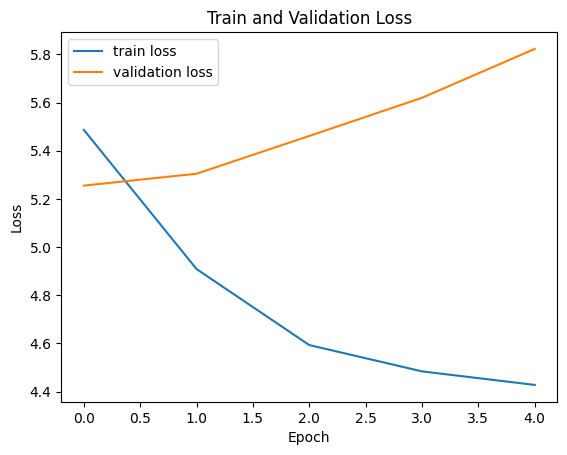

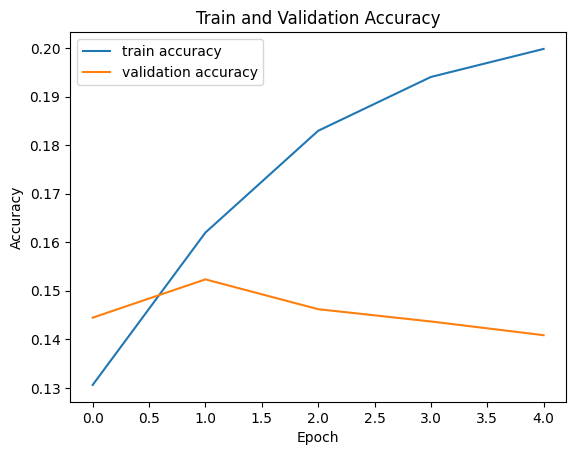

In [13]:
def visualise_results(history):

  plt.plot(history.history["loss"], label="train loss")
  plt.plot(history.history["val_loss"], label="validation loss")
  plt.title("Train and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.plot(history.history["accuracy"], label="train accuracy")
  plt.plot(history.history["val_accuracy"], label="validation accuracy")
  plt.title("Train and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

visualise_results(history)

In [47]:
test_model = MambaModel(1, vocab_size, 128)

test_model.load_weights("models/mamba_08_04_2024.weights.h5")

